# MDOF PINN - n-step ahead prediction

## Problem overview

The example problem we solve here is the MDOF oscillator defined by:
$$
m_1\ddot{x}_1 + (c_1+c_2)\dot{x}_1 - c_2\dot{x}_2 + (k_1 + k_2)x_1 - k_2x_2 = f_1
$$
$$
m_2\ddot{x}_2 + -c_2\dot{x}_1 + c_2\dot{x}_2 - k_2x_1 + k_2x_2 = f_2
$$
in state space:
$$
\dot{\mathbf{x}} = \mathbf{A}\mathbf{x} + \mathbf{H}\mathbf{f}
$$
where,
$$
\mathbf{x} = \begin{bmatrix} x_1 \\ x_2 \\ \dot{x}_1 \\ \dot{x}_2 \end{bmatrix}, \quad
\mathbf{f} = \begin{bmatrix} f_1 \\ f_2 \end{bmatrix}, \quad
\mathbf{A} = \begin{bmatrix} 0 & \mathbf{I} \\ -\mathbf{M}^{-1}\mathbf{K} & -\mathbf{M}^{-1}\mathbf{C} \end{bmatrix}, \quad
\mathbf{H} = \begin{bmatrix} 0 \\ -\mathbf{M}^{-1} \end{bmatrix}
$$
$$
\mathbf{M} = \begin{bmatrix} m_1 & 0 \\ 0 & m_2 \end{bmatrix}, \quad
\mathbf{K} = \begin{bmatrix} k_1+k_2 & -k_2 \\ -k_2 & k_2 \end{bmatrix}, \quad
\mathbf{C} = \begin{bmatrix} c_1+c_2 & -c_2 \\ -c_2 & c_2 \end{bmatrix}
$$
with the initial conditions
$$
\mathbf{x}(0) = \mathbf{x}_0~~,~~\dot{\mathbf{x}}(0) = \dot{\mathbf{x}}_0
$$

The aim is to predict the state at one-step ahead, using the previous displacement and velocity;
$$
\mathbf{x}^{(n+1)} = f(\mathbf{x}^{(n)})
$$

In [57]:
from mdof_osa_pinn import osa_pinn_mdof, normalise, ParamClipper
from mdof_oscillators import mdof_solution, add_noise, generate_excitation

import numpy as np
import torch
import torch.nn as nn

from scipy.stats import qmc

from tqdm import tqdm
from tqdm.auto import tqdm as tqdma

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


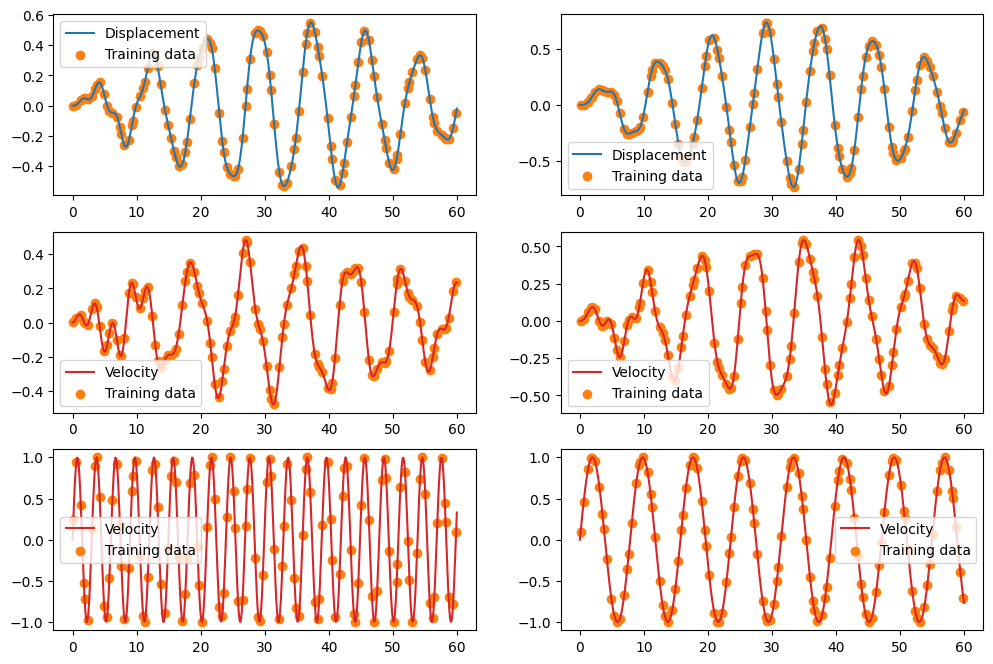

In [58]:
nt = 512
time = np.linspace(0,60,nt)

F0 = 1.0  # N
n_dof = 2

excitation = {
    "type" : "sinusoid",
    "n_dofs" : n_dof,
    "F0" : F0,
    "w" : [2.1, 0.8]  # rad/s
}

# excitation = {
#     "type" : "rand_phase_ms",
#     "n_dofs" : n_dof,
#     "F0" : F0,
#     "freqs" :   [np.array([0.7, 1.05, 1.3, 2.0]), np.array([0.7, 0.85, 1.6, 1.8])],
#     "Sx" :      [np.array([1.0, 1.0, 1.0, 1.0]), np.array([1.0, 1.0, 1.0, 1.0])],
# }

F = generate_excitation(time, **excitation)
excitation["F"] = F

### Generate training/ground truth data
k1 = 15.0; k2 = 30.0
c1 = 0.25; c2 = 0.75
m1 = 10.0; m2 = 15.0
M = np.array([[m1, 0],[0, m2]])
C = np.array([[c1+c2, -c2],[-c2, c2]])
K = np.array([[k1+k2, -k2],[-k2, k2]])

config = {
    "time_" : time,
    "nonlinearity" : "linear",
    "n_dofs" : n_dof,
    "params" : {
        "M" : M,
        "K" : K,
        "C" : C,
    },
    "init_conds" : {
        "x0" : [0.0, 0.0],
        "v0" : [0.0, 0.0]
    },
    "forcing" : excitation
}

xx, vv = mdof_solution(time, **config)
time = torch.tensor(time).view(-1,1).to(torch.float32)
F = torch.tensor(F).to(torch.float32)

# slice out a number of points
sampler = qmc.Sobol(d=1, seed=43810)
sub_ind = np.sort(sampler.integers(l_bounds=nt, n=int(nt/4)), axis=0).squeeze()
# sub_ind = np.arange(0, int(nt/1), 4)

t_data = time[sub_ind]
x_data = xx[sub_ind,:]
v_data = vv[sub_ind,:]
F_data = F[sub_ind,:]

fig, axs = plt.subplots(3,2,figsize=(12,8))

for i in range(2):
    axs[0,i].plot(time, xx[:,i], color="tab:blue", label="Displacement")
    axs[0,i].scatter(t_data, x_data[:,i], color="tab:orange", label="Training data")
    axs[0,i].legend()

    axs[1,i].plot(time, vv[:,i], color="tab:red", label="Velocity")
    axs[1,i].scatter(t_data, v_data[:,i], color="tab:orange", label="Training data")
    axs[1,i].legend()

    axs[2,i].plot(time, F[:,i], color="tab:red", label="Velocity")
    axs[2,i].scatter(t_data, F_data[:,i], color="tab:orange", label="Training data")
    axs[2,i].legend()

Normalise and create some plotting functions

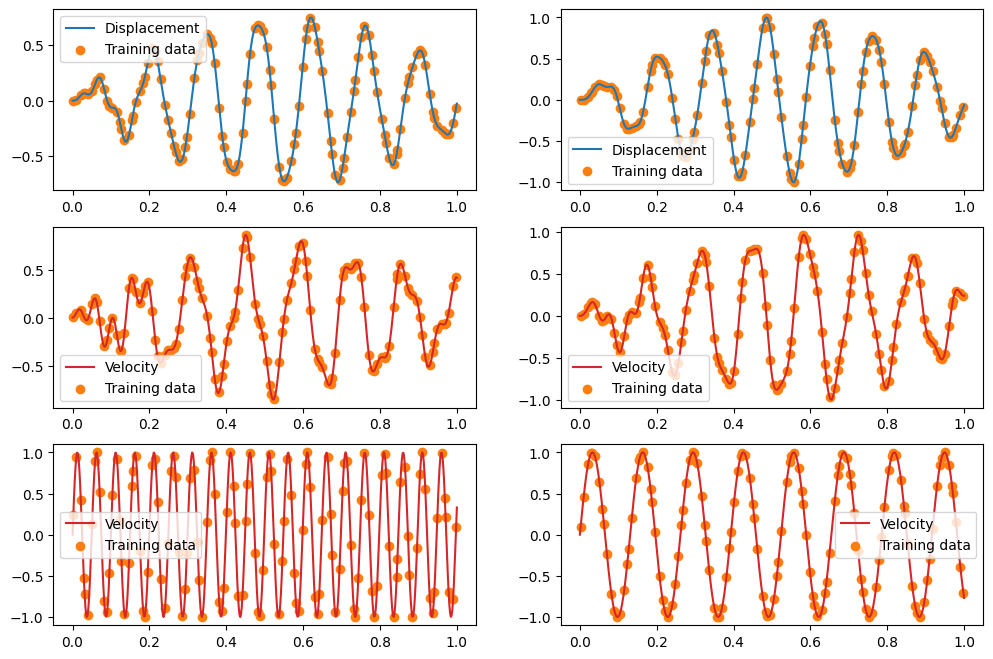

In [59]:
t_hat, alpha_t = normalise(time, "range")
x_hat_gt, alpha_x = normalise(xx, "range", "all")
v_hat_gt, alpha_v = normalise(vv, "range", "all")
F_hat_gt, alpha_F = normalise(F, "range", "all")

t_data = t_hat[sub_ind]
x_data = x_hat_gt[sub_ind,:]
v_data = v_hat_gt[sub_ind,:]
F_data = F_hat_gt[sub_ind,:]

T_hat = t_data[1].item()-t_data[0].item()

fig, axs = plt.subplots(3,2,figsize=(12,8))

for i in range(2):
    axs[0,i].plot(t_hat, x_hat_gt[:,i], color="tab:blue", label="Displacement")
    axs[0,i].scatter(t_data, x_data[:,i], color="tab:orange", label="Training data")
    axs[0,i].legend()

    axs[1,i].plot(t_hat, v_hat_gt[:,i], color="tab:red", label="Velocity")
    axs[1,i].scatter(t_data, v_data[:,i], color="tab:orange", label="Training data")
    axs[1,i].legend()

    axs[2,i].plot(t_hat, F_hat_gt[:,i], color="tab:red", label="Velocity")
    axs[2,i].scatter(t_data, F_data[:,i], color="tab:orange", label="Training data")
    axs[2,i].legend()

In [60]:
def plot_joint_loss_hist(ax,loss_hist):
    n_epoch = len(loss_hist)
    labels = ["L_obs", "L_ic", "L_cc", "L_ode", "L"]
    colors = ["tab:blue", "tab:red", "tab:green", "tab:cyan", "black"]
    # labels = ["L_obs", "L_ic", "L_ode", "L_ed_b", "L_ed_p", "L"]
    # colors = ["tab:blue", "tab:red", "tab:green", "tab:orange", "tab:purple", "black"]
    ax.cla()
    for i in range(len(labels)):
        ax.plot(np.arange(1,n_epoch+1),loss_hist[:,i],color=colors[i],label=labels[i])
    ax.set_yscale('log')
    ax.legend()

def plot_result(axs_m, ground_truth, data, prediction, alphas, var_pred=None):
    for ax in axs_m:
        axs_m[ax].cla()
    axs = np.array([[axs_m['A'], axs_m['B']],[axs_m['C'], axs_m['D']]])
    plot_keys = ["x_hat", "v_hat"]
    for i in range(2):
        for j in range(2):
            axs[i,j].plot(ground_truth["t_hat"]*alphas["t"], ground_truth[plot_keys[i]][:,j]*alphas["x"], color="grey", linewidth=1, alpha=0.8, label="Exact solution")
            axs[i,j].plot(prediction["t_hat"]*alphas["t"], prediction[plot_keys[i]][:,j]*alphas["x"], color="tab:blue", linewidth=1, alpha=0.8, label="Neural network prediction")
            axs[i,j].scatter(data["t_hat"]*alphas["t"], data[plot_keys[i]][:,j]*alphas["x"], s=60, color="tab:orange", alpha=0.4, label='Training data')
            if var_pred is not None:
                axs[i,j].plot(var_pred["t_hat"]*alphas["t"], var_pred[plot_keys[i]][:,j]*alphas["x"], color="tab:cyan", alpha=0.4, label='Variable coll prediction')
            l = axs[i,j].legend(frameon=False, fontsize="large")
            xL = torch.amax(ground_truth["t_hat"])*alphas["t"]
            yL = torch.amax(torch.abs(ground_truth[plot_keys[i]][:,j]))*alphas["x"]
            axs[i,j].set_xlim(-0.05*xL, 1.05*xL)
            axs[i,j].set_ylim(-1.1*yL, 1.1*yL)

ground_truth = {
    "t_hat" : t_hat,
    "x_hat" : x_hat_gt,
    "v_hat" : v_hat_gt,
    "F_hat" : F_hat_gt
}

data = {
    "t_hat" : t_data,
    "x_hat" : x_data,
    "v_hat" : v_data,
    "F_hat" : F_data,
    "sub_ind" : sub_ind
}

## PINN

Neural network predicts within a time horizon, given the current state and force:
$$
\mathcal{N}_{\mathbf{x}}(\mathbf{x}_0,t,\mathbf{f}_0), \qquad 
\mathbf{R} = \partial_t \mathcal{N}_{\mathbf{x}} - \mathbf{A} \mathcal{N}_{\mathbf{x}} - \mathbf{H}\mathbf{f}
$$

$$
\mathcal{L}(x_0,v_0,t;\mathbf{\theta}) := \mathcal{L}_{obs} + \mathcal{L}_{ic} + \Lambda\mathcal{L}_{ode}
$$

$$
\mathcal{L}_{obs} = \langle \hat{\mathbf{x}}^* - \mathcal{N}_{\hat{\mathbf{x}}} \rangle _{\Omega\in\{t=T\}}
% \mathcal{L}_{cc} = \sum_{j=1}^{N_{d}} \left\langle \alpha_{\dot{x}}\mathcal{N}_{\hat{\dot{x}}_j} - \frac{\alpha_x}{\alpha_t}\partial_{\hat{t}} \mathcal{N}_{\hat{x}_j} \right\rangle _{\Omega_d}
$$
$$
\mathcal{L}_{ic} = \sum_{j=1}^{N_{d}}\left[ 
\left\langle \alpha_{\dot{x}}\hat{\dot{x}}_{j,0} - \frac{\alpha_x}{\alpha_t}\partial_{\hat{t}}\mathcal{N}_{\hat{x}_j} \right\rangle ~~ + ~~
\left\langle \alpha_{x}\hat{x}_{j,0} - \alpha_x\mathcal{N}_{\hat{x}_j} \right\rangle ~~ + ~~
\left\langle \alpha_{\dot{x}}\hat{\dot{x}}_{j,0} - \alpha_{\dot{x}}\mathcal{N}_{\hat{\dot{x}}_j} \right\rangle
\right] _{\Omega\in\{t=0\}}
$$
$$
\mathcal{L}_{cc} = \sum_{j=1}^{N_{d}} \left\langle \mathbf{R}[j,:] \right\rangle _{\Omega_p}, \qquad
\mathcal{L}_{ode} = \sum_{j=1}^{N_{d}} \left\langle \mathbf{R}[N_d+j,:] \right\rangle _{\Omega_p}
$$
where,
$$ \mathcal{N}_{\bullet} = \mathcal{N}_{\bullet}(\mathbf{x};\mathbf{\theta}), \qquad 
\partial_{*}\bullet = \frac{\partial\bullet}{\partial *}, \qquad 
\partial^2_{*}\bullet = \frac{\partial^2\bullet}{\partial *^2}, \qquad
\langle\bullet\rangle _{\Omega_{\kappa}} = \frac{1}{N_{\kappa}}\sum_{t\in\Omega_{\kappa}}\left|\left|\bullet\right|\right|^2 $$

ODE loss function comes from including the normalisation of the parameters, then choosing the suitable range to aid optimisation.

$$
\frac{1}{\alpha_t^2} \partial^2_{\hat{t}}\hat{x} + 
\tilde{c}\frac{1}{\alpha_t}\partial_{\hat{t}}\hat{x} + 
\tilde{k} \hat{x} - 
\frac{\alpha_F}{\alpha_x} \hat{F} = 0 
\quad \rightarrow \quad 
\hat{m} \partial^2_{\hat{t}}\hat{x} + 
\hat{c} \partial_{\hat{t}}\hat{x} + 
\hat{k}\hat{x} - \eta\hat{F} = 0
$$
To scale loss function in a physically meaningful way, multiply the loss function by any of the following:
$$
\Lambda = 1, \alpha_t, \alpha_t^2, \alpha_x^, \alpha_F^{-1}
$$

Epoch : 2000000 ---- Loss: 4.40e-03


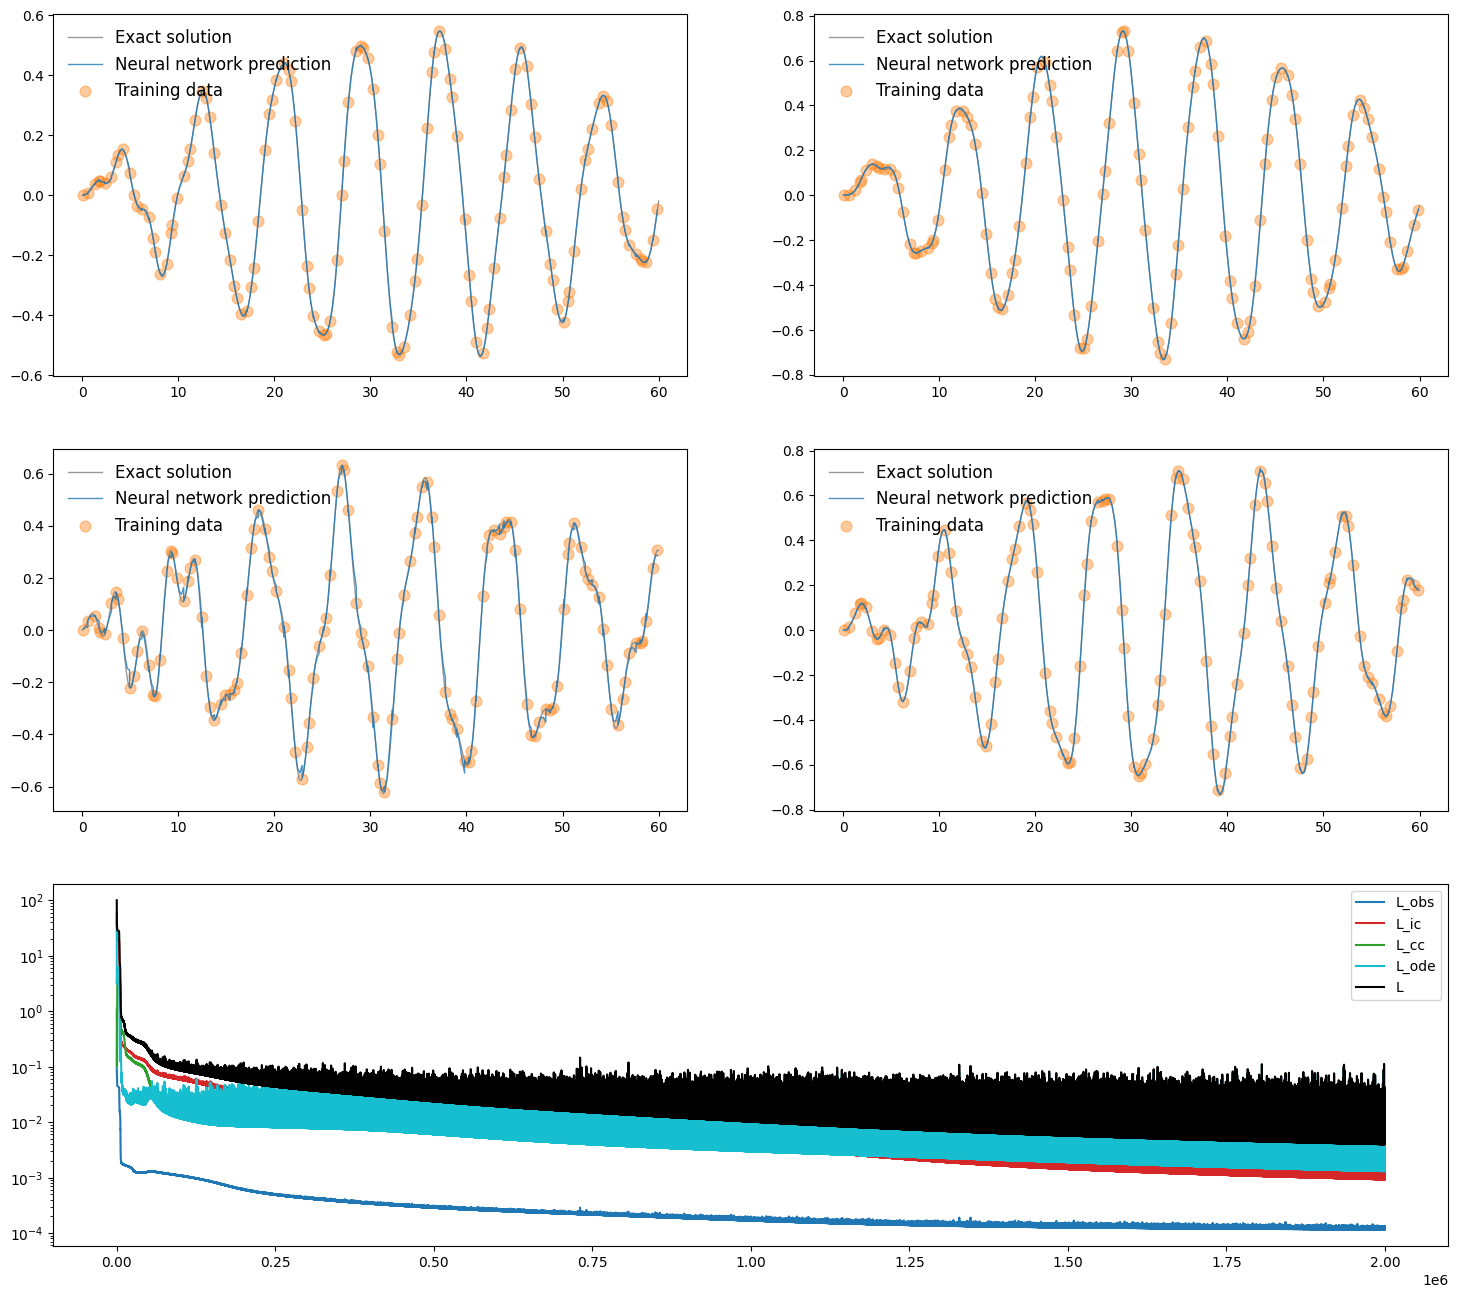

In [61]:
alpha_c = 1.0
alpha_k = 10.0
alphas = {
    "c" : alpha_c,
    "k" : alpha_k,
    "t" : alpha_t,
    "x" : alpha_x,
    "v" : alpha_v,
    "F" : alpha_F
}

nct = 4  # number of collocation points in time window

torch.manual_seed(123)

osa_config = {
    "n_input" : 3*n_dof + 1,
    "n_output" : 2*n_dof,
    "n_hidden" : 16,
    "n_layers" : 4,
    "n_dof" : n_dof,
    "nct" : nct,
    "nonlinearity" : "linear",
    # "phys_params" : {
    #     "par_type" : "variable",
    #     "k": 1.0,
    #     "c" : 1.0,
    #     "ed_nct" : 1024
    # },
    "phys_params" : {
        "par_type" : "constant",
        "K": torch.tensor(K, dtype=torch.float32),
        "C" : torch.tensor(C, dtype=torch.float32),
        "M" : torch.tensor(M, dtype=torch.float32),
    },
    "alphas" : alphas,
    "ode_norm_Lambda" : alpha_x.item(),
    "forcing" : excitation
}

# configure PINN
osa_model = osa_pinn_mdof(osa_config)
t_pred = osa_model.set_colls_and_obs(t_data, x_data, v_data, F_data)

# configure optimiser
learning_rate = 2e-4
betas = (0.9,0.999)
optimizer = torch.optim.Adam(osa_model.parameters(), lr=learning_rate, betas=betas)

clipper = ParamClipper()

# learning_rate = 5e-3
# max_iter = 50
# optimizer = torch.optim.LBFGS(osa_model.parameters(), lr=learning_rate, max_iter=max_iter)

fig, axs = plt.subplot_mosaic(
    "AB;CD;EE",
    figsize=(18,16),
    facecolor='w'
)

print_step = 500
loss_hist=[]
lambds = {
    'obs' : 0.1,
    'ic' : 100.0,
    'ode' : 1000.0,
    'cc' : 100.0,
    'ed_b' : 10.0,
    'ed_p' : 50.0,
}

epochs = int(2e6)
for i in tqdm(range(epochs)):

    # def closure():
    #     optimizer.zero_grad()
    #     loss, losses = osa_model.loss_func(lambds)
    #     loss_hist.append([loss_it.item() for loss_it in losses] + [loss.item()])
    #     loss.backward()
    #     return loss
    
    # optimizer.step(closure)

    optimizer.zero_grad()
    loss, losses = osa_model.loss_func(lambds)
    loss_hist.append([loss_it.item() for loss_it in losses] + [loss.item()])
    loss.backward()
    optimizer.step()

    # osa_model.apply(clipper)

    if (i+1) % print_step == 0:

        X_pred = osa_model.predict()

        # x_pred, xpred_ed, t_ed = osa_model.predict()
        # var_pred = {
        #     "t_hat" : t_ed.detach(),
        #     "x_hat" : xpred_ed.detach()
        # }

        prediction = {
            "t_hat" : t_pred,
            "x_hat" : X_pred.detach()[:,:n_dof],
            "v_hat" : X_pred.detach()[:,n_dof:]
        }

        plot_result(axs, ground_truth, data, prediction, alphas)

        plot_joint_loss_hist(axs['E'], np.array(loss_hist))

        display.clear_output(wait=True)
        display.display(plt.gcf())
        match osa_model.param_type:
            case "constant":
                tqdma.write("Epoch : %d ---- Loss: %.2e" % (i+1,loss_hist[i][-1]))
            case "variable":
                tqdma.write("Epoch : %d ---- Loss: %.2e \nc_tild: %.4f ---- k_tild: %.4f" % (i+1,loss_hist[i][-1],osa_model.phys_params[0]*alphas['c'],osa_model.phys_params[1]*alphas['k']))

display.clear_output()
match osa_model.param_type:
    case "constant":
        tqdma.write("Epoch : %d ---- Loss: %.2e" % (i+1,loss_hist[i][-1]))
    case "variable":
        tqdma.write("Epoch : %d ---- Loss: %.2e \nc_tild: %.4f ---- k_tild: %.4f" % (i+1,loss_hist[i][-1],osa_model.phys_params[0]*alphas['c'],osa_model.phys_params[1]*alphas['k']))
        

In [62]:
# result_data = {
#     'epoch' : i,
#     'gt_config' : config,
#     'osa_config' : osa_config,
#     'model' : osa_model.state_dict(),
#     'loss' : loss_hist,
#     'ground_truth' : ground_truth,
#     'data' : data,
#     'prediction' : prediction,
#     'alphas' : alphas
# }

# torch.save(result_data, 'results/osa_free_linear.pth')

In [63]:
checkpoint = {
    'epoch' : i,
    'model' : osa_model.state_dict(),
    'optimizer' : optimizer.state_dict(),
    'loss' : loss_hist,
    "sdof_config" : config,
    "pinn_config" : osa_config
}

torch.save(checkpoint,'checkpoints/sdof_free_osa.pth')

RuntimeError: Parent directory checkpoints does not exist.